<a href="https://colab.research.google.com/github/wonmyeong/olive-young/blob/master/BernoulliNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tweepy==3.10

In [ ]:
try:
    import konlpy
except:
    !pip install -q konlpy
    import konlpy

import pandas as pd
import numpy as np

konlpy.__version__

'0.6.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
data_df = pd.read_csv("//content//drive//MyDrive//oliveyoung_paper//concat_review_df")

In [ ]:
data_df.drop(columns=["Unnamed: 0"],inplace=True)

In [ ]:
data_df

,review,label
0,유통기한도 넉넉하고,1
1,구성도 많아서 선물 하기 좋네요.,1
2,구성도알차고,1
3,촉촉하고너무좋아용,1
4,대용량으로 넉넉하게 사용할 수 있고,1
...,...,...
2995,구성도 아쉽지만,0
2996,오랫동안 촉촉하지 않아요.,0
2997,촉촉하지 않아요.,0
2998,목 주름 개선 효과도 없는 것 같습니다.,0


In [ ]:
## okt 형태소 분석기를 활용한 불용어 제거
from konlpy.tag import Okt
okt = Okt()
def clean_text(text):
      tokens = okt.pos(text)
      # 조사, 구두점, 알파벳을 제외
      tokens = [(word, pos) for word, pos in tokens if pos not in ['Josa', 'Punctuation', 'Alpha']]
      # Extract only the words from the first element of each tuple
      words = [word for word, _ in tokens]

      # Join the words together to form a sentence
      cleaned_text = ' '.join(words)  # 공백 없이 한글 단어들을 연결합니다.

      return cleaned_text


data_df['review'] = data_df['review'].apply(lambda x: clean_text(x))

text_test = data_df['review'].values
y_test = data_df['label'].values

In [ ]:
from konlpy.tag import Okt

class PicklableOkt(Okt):
    def __init__(self, *args):
        self.args = args
        Okt.__init__(self, *args)

    def __getstate__(self):
        return {'args': self.args}

    def __setstate__(self, state):
        self.__init__(*state['args'])


In [ ]:
#### 나이브 베이즈 분류 시작

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
model = BernoulliNB()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV #최적의 파라미터 값을 찾는 라이브러리

# 직렬화 가능한 PickableOkt 사용하여 파이프라인 생성
param_grid = {
    'tfidfvectorizer__min_df': [3],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'bernoullinb__alpha': [0.1, 1, 10]
}

pipe = make_pipeline(TfidfVectorizer(tokenizer=PicklableOkt().morphs), BernoulliNB())
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(tokenizer=<bound method Okt.morphs of <__main__.PicklableOkt object at 0x7caffc099090>>)),
                                       ('bernoullinb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'bernoullinb__alpha': [0.1, 1, 10],
                         'tfidfvectorizer__min_df': [3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [ ]:
print("최적의 교차 검증 점수 : {:.2f}".format(grid.best_score_))
print("최적의 매개변수 : \n",grid.best_params_)

최적의 교차 검증 점수 : 0.83
최적의 매개변수 : 
 {'bernoullinb__alpha': 0.1, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}


#BernoulliNB 모델 점수 시각화

In [ ]:
!pip install mglearn

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

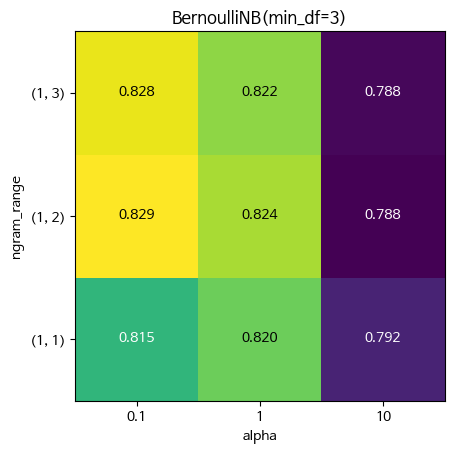

In [ ]:
#매개변수 히트맵
import mglearn

scores = grid.cv_results_["mean_test_score"].reshape(-1,3).T
heatmap = mglearn.tools.heatmap(
    scores,xlabel="alpha",ylabel="ngram_range", cmap="viridis",fmt="%.3f",
    xticklabels = param_grid["bernoullinb__alpha"],
    yticklabels = param_grid["tfidfvectorizer__ngram_range"]

)

plt.title("BernoulliNB(min_df=3)")
plt.show()

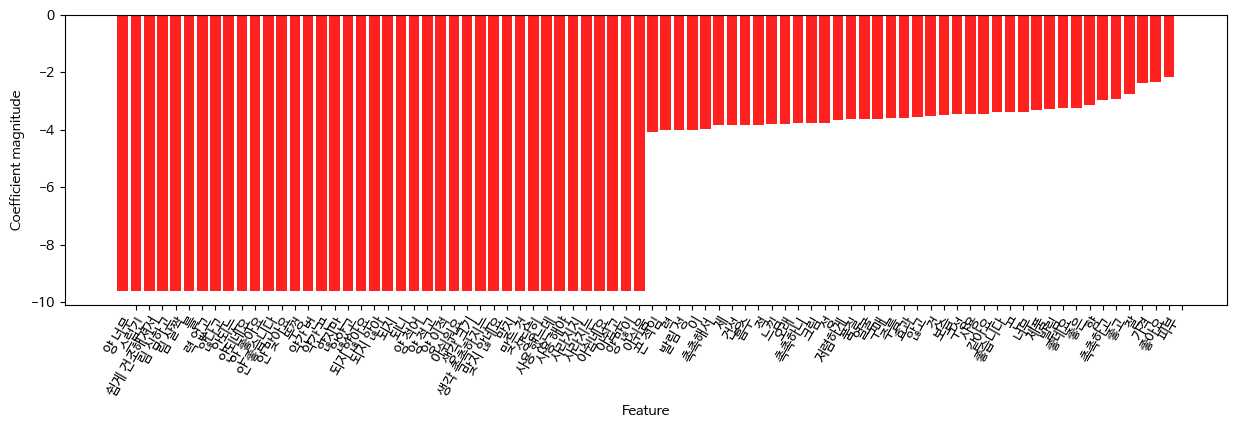

In [ ]:
# BernoulliNB 모델 사용 시
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['bernoullinb'].feature_log_prob_
mglearn.tools.visualize_coefficients(coef[1], feature_names, n_top_features=40)


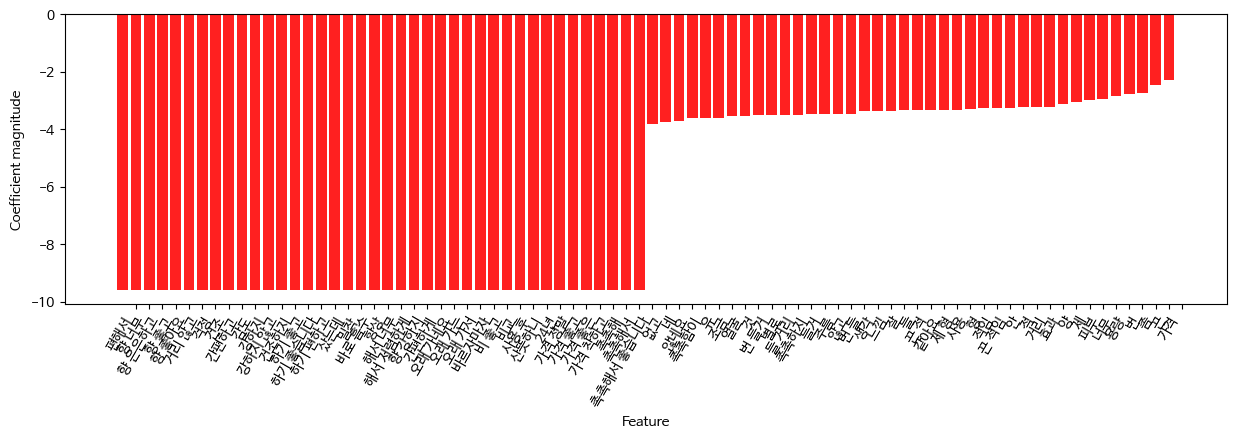

In [ ]:
# BernoulliNB 모델 사용 시
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['bernoullinb'].feature_log_prob_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)

In [ ]:
final_olive_review = pd.read_csv("//content//drive//MyDrive//oliveyoung_paper//final_olive_review_data_df")
final_olive_review.drop(columns={"Unnamed: 0"},inplace=True)

In [ ]:
## 테스트 데이터 결측치 제
missing_values = final_olive_review['reviews'].isna().sum()

# If there are missing values, drop the corresponding rows
if missing_values > 0:
    final_olive_review.dropna(subset=['reviews'], inplace=True)

In [ ]:
x_test = final_olive_review['reviews']
y_test = final_olive_review['rating']

In [ ]:
# Create an empty list to store predicted classes
predicted_classes = []

# Iterate over each review in the DataFrame column
for review in final_olive_review['reviews']:
    # Make prediction using the best estimator found by GridSearchCV
    predicted_class = grid.predict([review])

    # Append the predicted class to the list
    predicted_classes.append(predicted_class[0])  # Access the predicted class (it's a numpy array) and append

# Add the predicted classes as a new column named 'prediction' to the DataFrame
final_olive_review['prediction'] = predicted_classes



In [ ]:
final_olive_review

,userId,rating,reviews,prediction
0,와바밤,1,사실 마스크 팩 한 달동 안 사용 것 아니라 한 달 리뷰 하기 얘 매하 긴한데 어쩃...,1
1,와바밤,1,배송비 가격 맞출 때 유용하게 매번 구매 있습니다 자극 없이 순해여,1
2,보부상출신,1,나이 먹으니까 피부 고민 점차 주름 미백 쪽 빠지는데데 일리 피부 결 톤 케어 하기...,1
3,파이지니,1,🌼 1일 1 팩 하기 좋은 가성 비 마스크 팩 🌼 메디 힐 마스크 팩 너무 유명하죠...,1
4,보부상출신,1,요즘 제 피부 상태 탄력 지금 저 세상 가있는데 복구 위해 콜라겐 마스크 팩 이용 ...,1
...,...,...,...,...
595,nam****,0,에센스 피부 오히랴 건조하게 하는 느낌 이였어용 ㅠㅠ 일시 적 보습 력 있고 그 이...,0
596,dltnw****,0,항상 즐겨 쓰는 팩 입니다아 얼굴 크기 적당하게 잘 맞고 많이 예민해서 아무 거나 ...,1
597,puk****,0,문 앞 놔 달라 했는데 경비실 놓고가서 없어진줄 알 당황 했어 욪 택배 기사 님 이...,1
598,sojung2****,0,10 개 이상 구매 하면 박스 오는줄 알았는데 낱개 와서 아쉬워요 팩 원래 이렇게 ...,0


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,final_olive_review['prediction'])

In [ ]:
print("모델 분류 정확도 : {:.2f}".format(accuracy))

모델 분류 정확도 : 0.71


### 평점 3점 소비자 의견 데이터 긍/부정 분류

In [ ]:
olive_med_df = pd.read_csv("//content//drive//MyDrive//oliveyoung_paper//olive_young_med_df")

In [ ]:
import re
olive_med_df['reviews'] = olive_med_df.reviews.apply(lambda x: re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', '', x))

In [ ]:

# Create an empty list to store predicted classes
predicted_classes = []

# Iterate over each review in the DataFrame column
for review in olive_med_df['reviews']:
    # Make prediction using the best estimator found by GridSearchCV
    predicted_class = grid.predict([review])

    # Append the predicted class to the list
    predicted_classes.append(predicted_class[0])  # Access the predicted class (it's a numpy array) and append

# Add the predicted classes as a new column named 'prediction' to the DataFrame
olive_med_df['prediction'] = predicted_classes

###3점 평점 데이터 긍/부정 나눠서 각각의 데이터 프레임에 추가하기

In [ ]:
olive_med_df.drop(columns=["userId","rating","Unnamed: 0"],inplace=True)
olive_med_df.rename(columns={"prediction":"rating"},inplace=True)

In [ ]:
olive_med_df.head()

,reviews,rating
0,메디힐 마스크 팩 티트리콜라겐시카등등 종류별대로 사용 해 보다가피부톤이 얼룩덜룩하고...,1
1,데일리로 그냥 쓰기 좋은 제품데일리로 그냥 쓰기 좋은 제품 n,1
2,머 저렴이로 매일 붙히기 부담없는 정도머 저렴이로 매일 붙히기 부담없는 정도머 ...,1
3,마스크팩했을 때 확실히 얼굴이 환해지기는 하는데 원래 피부가 수분 먹으면 환해지는 ...,1
4,트러블이 들어간다는 건 잘 모르겠는데 붉은 기는 잘 없애주는 듯 근데 내 피부 기준...,0


### 라벨링한 데이터를 원래 올리브영 데이터와 합치기

In [ ]:
olive_med_labeled_pos_df = olive_med_df[olive_med_df['rating'] == 1]

In [ ]:
olive_med_labeled_pos_df.shape

(211, 2)

In [ ]:
olive_pos_df = final_olive_review[final_olive_review["rating"] == 1]

In [ ]:
olive_pos_df.drop(columns=["userId","prediction"],inplace=True)

<ipython-input-182-574b2ac96cef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  olive_pos_df.drop(columns=["userId","prediction"],inplace=True)


In [ ]:
olive_pos_df.rating.unique()

array([1])

In [ ]:
#olive_med_labeled_pos_df 와 olive_pos_df 합치기
final_pos_df = pd.concat([olive_med_labeled_pos_df,olive_pos_df],ignore_index=True)

In [ ]:
final_pos_df.shape

(510, 2)

###워드 클라우드 만들기


In [ ]:
##형태소 분석
import numpy as np
import pandas as pd


In [ ]:
tokenizer = Okt()
final_pos_df['tokenized'] = final_pos_df['reviews'].apply(tokenizer.nouns)

In [ ]:
final_pos_df.head()

,reviews,rating,tokenized
0,메디힐 마스크 팩 티트리콜라겐시카등등 종류별대로 사용 해 보다가피부톤이 얼룩덜룩하고...,1,"[힐, 마스크, 팩, 티, 트리, 콜라겐, 카, 등등, 종류, 별대, 해, 톤, 뾰..."
1,데일리로 그냥 쓰기 좋은 제품데일리로 그냥 쓰기 좋은 제품 n,1,"[데, 일리, 쓰기, 데, 일리, 쓰기]"
2,머 저렴이로 매일 붙히기 부담없는 정도머 저렴이로 매일 붙히기 부담없는 정도머 ...,1,"[머, 저렴, 매일, 부담, 정도, 머, 저렴, 매일, 부담, 정도, 머, 저렴, ..."
3,마스크팩했을 때 확실히 얼굴이 환해지기는 하는데 원래 피부가 수분 먹으면 환해지는 ...,1,"[마스크, 팩, 때, 지기, 원래, 수분, 거, 거, 잡티, 케어, 도움]"
4,콜라겐 궁금해서 구매해 봄 한 번으로는 효과 없는 게 뻔하니까 몇 개 더 구매했었는...,1,"[콜라겐, 봄, 번, 효과, 게, 몇, 개, 더, 탄력, 도움, 이건]"


In [ ]:
positive_reviews = np.hstack(final_pos_df['tokenized'].values)

In [ ]:
#상품 불용어 제거
product_stop_words = ["피부","얼굴","구매","제품","정말","그냥","사용"]
positive_reviews = [word for word in positive_reviews if len(word) > 1 and word not in product_stop_words]


['마스크', '트리', '콜라겐', '등등', '종류', '별대', '뾰루지', '자리', '색소', '침착', '거뭇', '부분', '위해', '비타', '비타', '라서', '약간', '자극', '다른', '종류', '효과', '미미', '오히려', '다음', '스름', '토너', '정리', '불편', '비타', '가성', '제외', '일리', '쓰기', '일리', '쓰기', '저렴', '매일', '부담', '정도', '저렴', '매일', '부담', '정도', '저렴', '매일', '부담', '정도', '마스크', '지기', '원래', '수분', '잡티', '케어', '도움', '콜라겐', '효과', '탄력', '도움', '이건', '좁쌀', '뾰루', '트러블', '진정', '오히려', '상치', '자극', '마스크', '주변', '은기', '시트', '진정', '대박', '흡수', '보습', '진정', '재생', '허브', '관리', '효과', '진정', '한번', '한번', '효과', '진정', '한번', '한번', '효과', '관리', '관리', '마스크', '공장', '비위생적', '면서', '믿음', '에센스', '무난', '밀착', '몇개', '모낭', '트리', '효과', '유튜브', '지성', '마스크', '하나', '소개', '자극', '여행', '연속', '진정', '다음', '화장', '마스크', '진정', '병풀', '추출', '물이', '함유', '여름', '야외', '활동', '진정', '도움', '인지도', '용감', '트러블', '자극', '무엇', '진정', '쟁여두', '일리', '가격', '자주', '거의', '다음', '조금', '좁쌀', '다음', '트리', '금액', '기용', '의사', '종류', '선택', '무난', '쓰기', '마스크', '항상', '무난', '결혼식', '아버지', '사드', '매일', '수분', '보충', '마스크', '종류', '매번', '올리브영', '무난', '가족', '마스크', '

In [ ]:
final_pos_df['tokenized'] = final_pos_df['reviews'].apply(lambda x: [word for word in tokenizer.nouns(x) if word not in product_stop_words and len(word) > 1])


In [ ]:
final_pos_df.head()

,reviews,rating,tokenized
0,메디힐 마스크 팩 티트리콜라겐시카등등 종류별대로 사용 해 보다가피부톤이 얼룩덜룩하고...,1,"[마스크, 트리, 콜라겐, 등등, 종류, 별대, 뾰루지, 자리, 색소, 침착, 거뭇..."
1,데일리로 그냥 쓰기 좋은 제품데일리로 그냥 쓰기 좋은 제품 n,1,"[일리, 쓰기, 일리, 쓰기]"
2,머 저렴이로 매일 붙히기 부담없는 정도머 저렴이로 매일 붙히기 부담없는 정도머 ...,1,"[저렴, 매일, 부담, 정도, 저렴, 매일, 부담, 정도, 저렴, 매일, 부담, 정도]"
3,마스크팩했을 때 확실히 얼굴이 환해지기는 하는데 원래 피부가 수분 먹으면 환해지는 ...,1,"[마스크, 지기, 원래, 수분, 잡티, 케어, 도움]"
4,콜라겐 궁금해서 구매해 봄 한 번으로는 효과 없는 게 뻔하니까 몇 개 더 구매했었는...,1,"[콜라겐, 효과, 탄력, 도움, 이건]"


In [ ]:
from collections import Counter
from wordcloud import WordCloud
positive_reviews_word_count = Counter(positive_reviews)
word_freq = positive_reviews_word_count.most_common(20)
print(word_freq)
# wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', background_color='white')



[('마스크', 266), ('진정', 197), ('시트', 163), ('트리', 133), ('효과', 129), ('수분', 110), ('가격', 102), ('에센스', 89), ('무난', 82), ('보습', 76), ('트러블', 65), ('자극', 58), ('요즘', 55), ('밀착', 54), ('자주', 54), ('가성', 52), ('일리', 47), ('다음', 45), ('느낌', 44), ('정도', 42)]


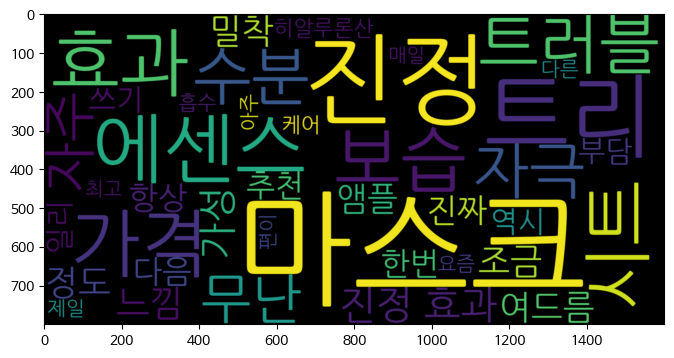

In [ ]:
# 긍정 리뷰의 워드 클라우드
temp_data = ' '.join(np.concatenate(final_pos_df.tokenized.reset_index(drop=True)))
wc = WordCloud(max_words = 40 , width = 1600 , height = 800, font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf').generate(temp_data)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation = 'bilinear')
wc.to_file("BernoulliNB_긍정 워드클라우드.png")

In [ ]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
!apt-get install fonts-nanum*
!apt-get install fontconfig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20200506-1).
The following NEW packages will be installed:
  fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 35.7 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0 MB]
Fetched 35.7 MB in 1s (38.0 MB/s)
Selecting previ